# GEOPORTTI - Syke's HPC exercise


## Goal 

 

In this exercise, you will perform a land cover classification for some Finnish region using [Lucas 2018](https://ckan.ymparisto.fi/en/dataset/lucas2018) inventory dataset and geospatial data from the [GeoCubes Finland](https://vm0160.kaj.pouta.csc.fi/geocubes/) service. After the classification, you will analyse the accuracy of the result and the relevance of the data you selected to use in this task. 

You will learn:
 * How to conduct a generalized land cover classification using the scikit-learn Python library
 * How to use and download data from the GeoCubes service
 * How to use Dask framework in CSC's Puhti supercomputer
 * How to interpret the classification results and improve them

## Background

This type of land cover interpretation provides the background for various environmental monitoring applications, such as the calculation of environmental indicators (e.g. "land degradation"), biotope inventories, nutrient loss modelling, assessment of the consequences of legislation or land use planning.  

The Finnish Environment Institute has long since the 1990s recognised the importance of such up-to-date spatial data, without forgetting the changes. SYKE has participated in the [European land cover monitoring](https://land.copernicus.eu/) since the early 2000s within the Corine programme, which has produced Corine land cover interpretations and modifications for the years 2000, 2006, 2012 and 2018. In addition, more local interpretations have been made with various partners, such as the remote sensing of Northern Lapland carried out for Metsähallitus in recent years. There are also various projects, such as FEO and Geoportti, which aim to improve the availability of environmental spatial information. 

More infromation: 

https://www.syke.fi/fi-FI/Avoin_tieto/Seurantatiedot/Maanpeitteen_seuranta 

 
## Input-data: 

1. **In-situ** 

    In this exercise the In-situ dataset is the Lucas 2018 land inventory dataset from Finland. LUCAS (Land USe and Coverage Area frame Survey) is a land inventory organised by EUROSTAT, the statistical office of the European Union, which collects data on land cover and land use from the survey plots. There are about 330,000 plots throughout the EU, of which about 17,000 are in Finland. Part of the data collection is done by field visits and part by interpreting aerial photographs.  



    The link https://a3s.fi/geoportti_training/lucas2018.tar provides Lucas 2018 scores for the whole country (lucas_2018.shp) and by province, with the main land cover group found in the column "lc_class": 

    1 = Build up areas 

    2 = Agriculture 

    3 = Forests

    4 = Sparsely vegetated forests 

    5 = Grasslands 

    6 = Unvegetated soil 

    7 = Water 

    8 = Wetlands


    A more detailed land cover class can be found in column LC1 (for more detailed information on land cover and use classes see https://ec.europa.eu/eurostat/documents/205002/8072634/LUCAS2018-C3-Classification.pdf if needed. 



 2. **Features**

 
    In this exercise, you will use raster datasets found in the [GeoCubes Finland](https://vm0160.kaj.pouta.csc.fi/geocubes/) -service as classification features.

    So, select a province and download the data of your choice, delimited by that province, using a pixel size of 10 m


 



 

 

### Import neccesary libraries

In [3]:
import rasterio
import rioxarray as rxr
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os,sys
import urllib
import multiprocessing
from dask import delayed
from dask import compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask
import dask.array as da
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from tqdm.notebook import tqdm
import itertools
sys.path.append('/projappl/project_2000630/bin/tpot')
sys.path.append(os.path.expanduser('/projappl/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo/src'))
import tpot
import argparse
import pickle
import point_eo.scripts.sample_xarray as sample_xarray # NOTE: this is my modification to original point-eo repo
import point_eo.scripts.analysis as analysis
import point_eo.scripts.tpot_train as tpot_train
import point_eo.scripts.predict as predict
import point_eo.scripts.postprocess_prediction as postprocess_prediction

# outputs are created here
basepth = '/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data'

In [1]:
# load geoconda module from Puhti's module sets
!module load geoconda

------------------------------------------
Geoconda 3.10.9, GIS libraries for Python
https://docs.csc.fi/apps/geoconda
------------------------------------------


## Create a Dask cluster and client

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45993")
client

<Client: 'tcp://127.0.0.1:45993' processes=4 threads=4, memory=30.00 GiB>

## Load the reference data from Allas

In [30]:
!mkdir /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data
!wget -P /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data https://a3s.fi/geoportti_training/lucas2018.tar

mkdir: cannot create directory ‘/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data’: File exists
--2024-02-06 12:42:36--  https://a3s.fi/geoportti_training/lucas2018.tar
Resolving a3s.fi (a3s.fi)... 86.50.254.18, 86.50.254.19
Connecting to a3s.fi (a3s.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65228800 (62M) [application/x-tar]
Saving to: ‘/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/lucas2018.tar.1’

lucas2018.tar.1     100%[===================>]  62.21M   346MB/s    in 0.2s    

2024-02-06 12:42:36 (346 MB/s) - ‘/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/lucas2018.tar.1’ saved [65228800/65228800]



In [35]:
!cd /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data
!tar -xf /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/lucas2018.tar -C '/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/'

In [4]:
lucas2018_lapland = gpd.read_file('/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/training_data/lucas2018_19_lappi.shp')
lucas2018_lapland.columns

Index(['OBJECTID', 'POINT_ID', 'OFFICE_PI', 'SURVEYDATE', 'OBS_DIST',
       'OBS_DIRECT', 'OBS_TYPE', 'LC1', 'LC2', 'LU1', 'LU2', 'LC1_name',
       'LU1_name', 'photolinkN', 'photolinkE', 'photolinkS', 'photolinkW',
       'photolinkP', 'LCluokka', 'maakunta_1', 'geometry'],
      dtype='object')

## Load input rasters from GeoCubes

In [4]:
def download_data(params):
    download_url = params[0]
    out_fn = params[1]
    print(f"Starting to download {download_url} \n")
    r = urllib.request.urlretrieve(download_url, out_fn)
    print(f"Download completed. Results saved to {out_fn}")

In [5]:
raster_list = [
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/ndvimax/maakuntajako:19/2021",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/km2/maakuntajako:19/2022",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/puustoisuusluokat/maakuntajako:19/2022",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/kasvillisuudenkorkeus/maakuntajako:19/2022",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/latvuspeitto/maakuntajako:19/2022",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/sentinel2-rgb/maakuntajako:19/2021",
    "https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/sentinel2-nir/maakuntajako:19/2021"]
    
outfp = ["/scratch/project_2000630/jutilaee/geoportti/input_data/ndvi_max_2021_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/km2_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/tree_classes_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/vegetation_height_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/canopy_cover_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_rgb_lapland.tif",
         "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_nir_lapland.tif"]

In [6]:
param_list = []

for i in range(len(raster_list)):
	param_list.append([raster_list[i], outfp[i]])

In [8]:
list_of_delayed_functions = []

for parameters in param_list:
    list_of_delayed_functions.append(delayed(download_data)(parameters))


In [9]:
%%time
with ProgressBar():
        compute(list_of_delayed_functions)

CPU times: user 242 ms, sys: 40 ms, total: 282 ms
Wall time: 5min 21s


## Rasterize training data


In [10]:
%%time
! gdal_rasterize /users/jutilaee/land_cover_classification/training_data/lucas2018_19_lappi.shp /scratch/project_2000630/jutilaee/geoportti/lucas2018_lapland.tif -ot "UInt16" \
    -a LCluokka \
    -tr 10 10 \
    -te 243095.91 7244045.217 627855.91 7776445.217 -co "COMPRESS=LZW"

0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 122 ms, sys: 31.9 ms, total: 154 ms
Wall time: 15.9 s


## Split multi-band rasters to single-band rasters

In [ ]:
%%time
def split_multiband_raster(input_path, output_folder):
    # Open the multiband raster
    ds = rxr.open_rasterio(input_path)

    # Get the number of bands
    num_bands = ds.shape[0]

    # Loop through each band
    for band_index in range(num_bands):
        # Get the band data
        band = ds[band_index]

        # Create the output file name
        output_name = f"s2_rgb_lapland_band{band_index + 1}.tif"
        output_path = os.path.join(output_folder, output_name)

        # Save the band as a single-band raster
        band.rio.to_raster(output_path)

        print(f"Band {band_index + 1} saved as {output_path}")

# Example usage
input_raster = "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_rgb_lapland.tif"
output_folder = "/scratch/project_2000630/jutilaee/geoportti/input_data"
split_multiband_raster(input_raster, output_folder)

## Create a datacube

In [5]:
%%time


def load_raster(raster, band_name):
    xds = rxr.open_rasterio(raster)
    return xds.rename(band_name)



def create_cube():
    ## Raster input data for sampling
    rasters = [
        "/scratch/project_2000630/jutilaee/geoportti/input_data/ndvi_max_2021_lapland.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/km2_lapland.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/tree_classes_lapland.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/vegetation_height_lapland.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/canopy_cover_lapland.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_rgb_lapland_band1.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_rgb_lapland_band2.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_rgb_lapland_band3.tif",
        "/scratch/project_2000630/jutilaee/geoportti/input_data/s2_nir_lapland.tif"
    ]
    band_names = [
        'ndvi_max', 'dem', 'tree_classes', 'veg_height', 'canopy_cover',
        's2_b4', 's2_b3', 's2_b2', 's2_nir'
    ]
    delayed_rasters = [
        dask.delayed(load_raster)(raster, band_names[i]) for i, raster in enumerate(rasters)
    ]
    rasters_to_merge = dask.compute(*delayed_rasters)
    cube = xr.merge(rasters_to_merge)
    cube = cube.transpose('band', 'y', 'x')
    return cube, band_names

cube, band_names = create_cube()

CPU times: user 54.8 ms, sys: 12.4 ms, total: 67.2 ms
Wall time: 2.49 s


In [6]:
cube

<xarray.Dataset>
Dimensions:       (band: 1, x: 38477, y: 53241)
Coordinates:
  * band          (band) int64 1
  * x             (x) float64 2.431e+05 2.431e+05 ... 6.278e+05 6.279e+05
  * y             (y) float64 7.776e+06 7.776e+06 ... 7.244e+06 7.244e+06
    spatial_ref   int64 0
Data variables:
    ndvi_max      (band, y, x) uint8 ...
    dem           (band, y, x) float32 ...
    tree_classes  (band, y, x) uint8 ...
    veg_height    (band, y, x) uint8 ...
    canopy_cover  (band, y, x) uint8 ...
    s2_b4         (band, y, x) uint16 ...
    s2_b3         (band, y, x) uint16 ...
    s2_b2         (band, y, x) uint16 ...
    s2_nir        (band, y, x) uint16 ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

## Store bands for point-eo sampling script

In [6]:
band_name_file = os.path.join(basepth,'band_names.txt')
with open(band_name_file, 'w') as fp:
    for item in band_names:
        fp.write("%s\n" % item)

## Sample raster using point-eo for sampling
Source: https://github.com/sykefi/point-eo

Note that now sampling from xarray cube, requires modifications to point-eo tool that are installed locally

In [10]:
%%time
input_shape = '/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/training_data/lucas2018_19_lappi.shp'
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
sample_xarray.add_args(subparsers)
args = parser.parse_args(['sample_raster',
    '--input', input_shape,
    '--input_raster', 'dummy_placeholder',
    '--target', 'LCluokka',
    '--band_names', band_name_file,
    '--out_folder', os.path.join(basepth,'sampled')])
# Set input_raster to xarray variable
args.input_raster = cube
sample_xarray.main(args)

Sampling xarray dataset using points from /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/training_data/lucas2018_19_lappi.shp
Using bandnames:
['ndvi_max',
 'dem',
 'tree_classes',
 'veg_height',
 'canopy_cover',
 's2_b4',
 's2_b3',
 's2_b2',
 's2_nir']
Saved outputs to /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
CPU times: user 36.5 s, sys: 11.6 s, total: 48.1 s
Wall time: 1min


In [11]:
df = pd.read_csv('/scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv')

In [16]:
df

,LCluokka,ndvi_max,dem,tree_classes,veg_height,canopy_cover,s2_b4,s2_b3,s2_b2,s2_nir
0,6,112.0,859.72390,30.0,255.0,127.0,1047.0,977.0,841.0,1500.0
1,6,113.0,778.58010,30.0,255.0,127.0,1135.0,1103.0,995.0,1510.0
2,5,142.0,699.85986,30.0,255.0,127.0,743.0,730.0,600.0,2150.0
3,3,178.0,197.96394,11.0,4.0,15.0,224.0,423.0,271.0,3281.0
4,3,167.0,151.15020,11.0,3.0,2.0,267.0,429.0,311.0,2159.0
...,...,...,...,...,...,...,...,...,...,...
2593,8,143.0,190.24814,11.0,0.0,0.0,439.0,428.0,343.0,1717.0
2594,5,160.0,237.98238,30.0,255.0,127.0,491.0,561.0,346.0,2536.0
2595,3,155.0,173.44019,11.0,47.0,20.0,383.0,468.0,328.0,1888.0
2596,8,156.0,226.75183,30.0,0.0,0.0,625.0,613.0,399.0,2489.0


## Training with TPOT AutoML-tool

In [3]:
####  tpot, model is later used with analysis
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
tpot_train.add_args(subparsers)
args = parser.parse_args(['tpot_train',
    '--input', os.path.join(basepth,'sampled','xarray__lucas2018_19_lappi__LCluokka.csv'),
    '--out_folder', os.path.join(basepth,'tpot_train'),
    '--out_prefix','myexperiment',
    '--population_size','100',
    '--generations','10',
    '--decimal', '.',
    '--sep',','])
tpot_train.main(args)

Columns. First one is chosen as target
Index		Column
0		LCluokka
1		ndvi_max
2		dem
3		tree_classes
4		veg_height
5		canopy_cover
6		s2_b4
7		s2_b3
8		s2_b2
9		s2_nir


Target class distribution
label	count

Classes smaller than 6 are removed:
[]

Shape of X: (2598, 9)
Processing...


Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7117238183503243

Generation 2 - Current best internal CV score: 0.7131580166821131

Generation 3 - Current best internal CV score: 0.7146014828544949

Generation 4 - Current best internal CV score: 0.7160495829471734

Generation 5 - Current best internal CV score: 0.7189341983317888

Generation 6 - Current best internal CV score: 0.7189341983317888

Generation 7 - Current best internal CV score: 0.7189341983317888

Generation 8 - Current best internal CV score: 0.7189341983317888

Generation 9 - Current best internal CV score: 0.7189341983317888

Generation 10 - Current best internal CV score: 0.7189492585727526

Best pipeline: ExtraTreesClassifier(SelectPercentile(input_matrix, percentile=51), bootstrap=True, criterion=gini, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=9, n_estimators=100)
Done

 RUN STATISTICS:
0.7096153846153846

Fold 0:

RF:
RandomForestClassifier()
Accuracy: 0.715
Precision: 0.678
F1: 0.6

Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Model: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/tpot_train/myexperiment_acc0.7156_240206T141248.py
Model: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/tpot_train/myexperiment_acc0.7156_240206T141248.py
Model: /sc

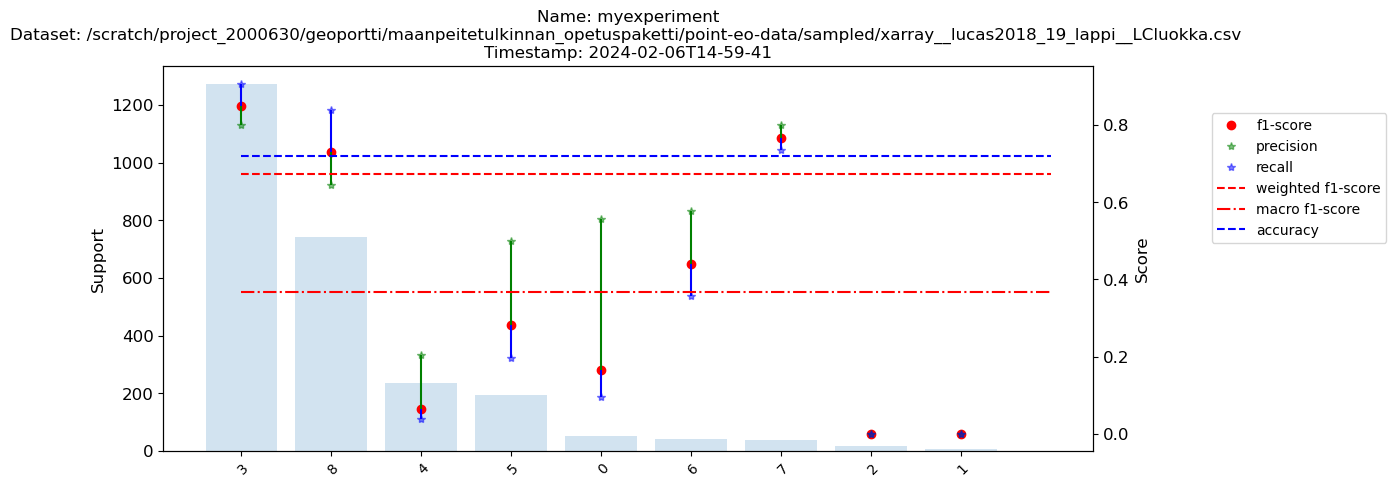

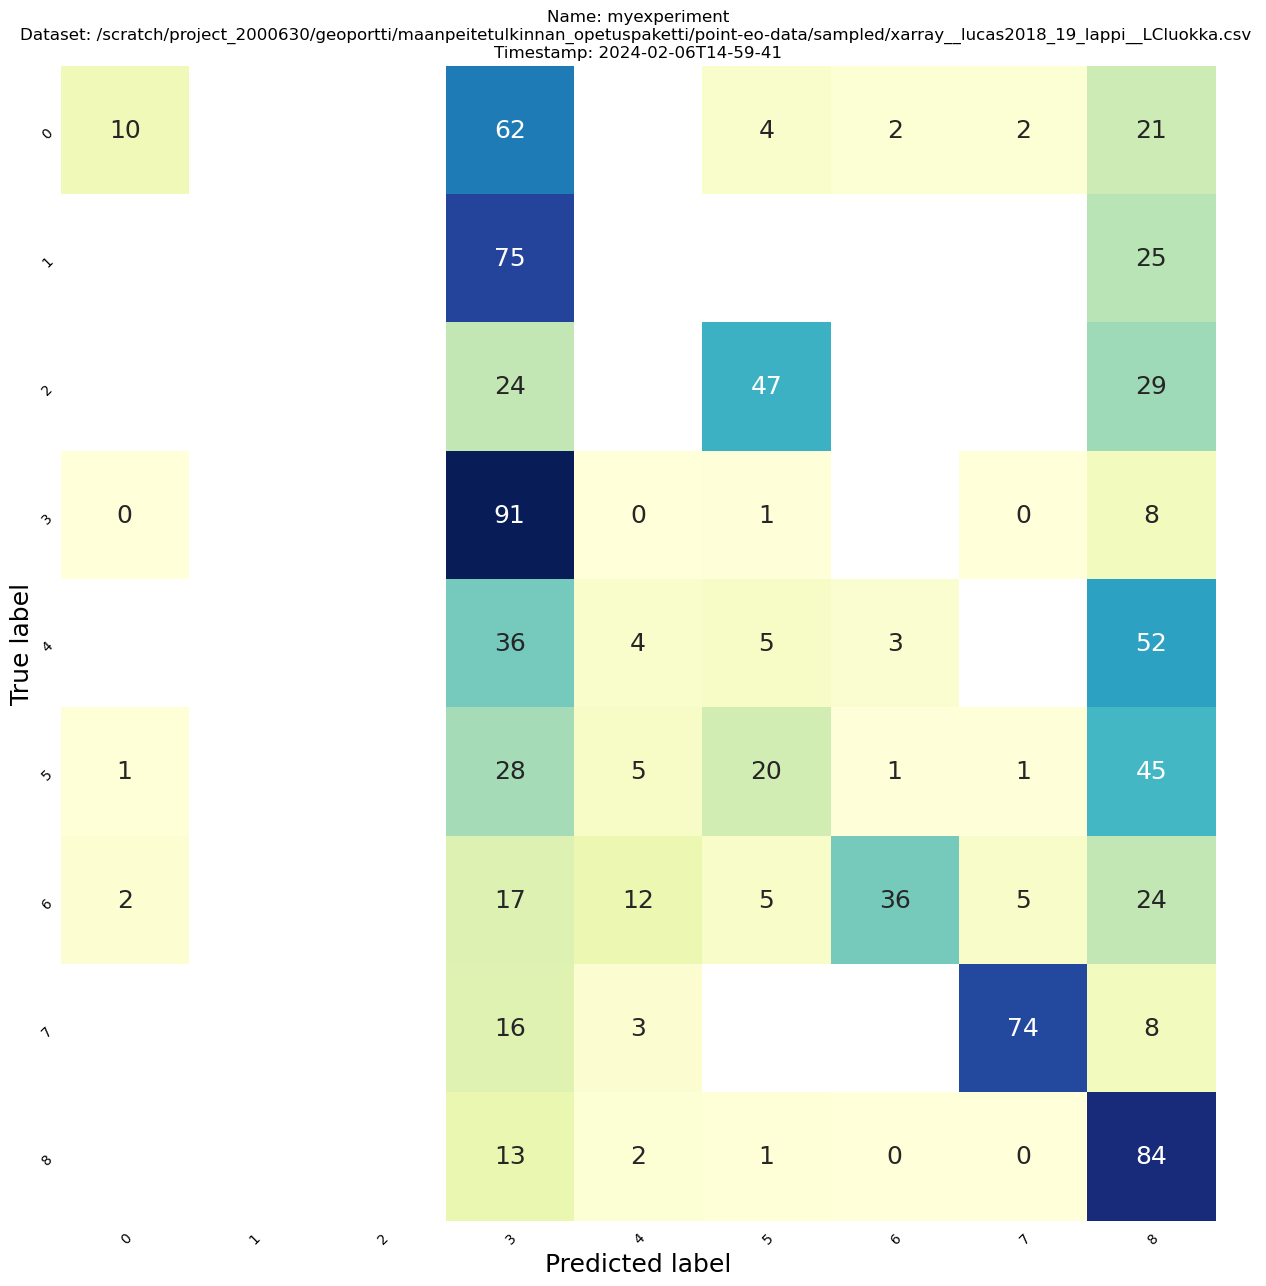

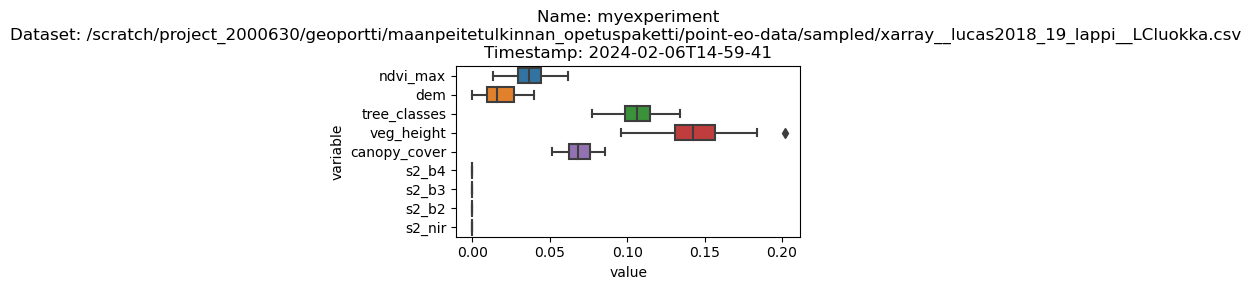

In [8]:
####  Training, analysis with tpot model
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
analysis.add_args(subparsers)
args = parser.parse_args(['analysis',
    '--input', os.path.join(basepth,'sampled','xarray__lucas2018_19_lappi__LCluokka.csv'),
    '--out_folder', os.path.join(basepth,'model_fitting_tpot'),
    '--out_prefix', 'myexperiment',
    '--tpot_model',os.path.join(basepth,'tpot_train','myexperiment_acc0.7156_240206T141248.py'),
    '--decimal', '.',
    '--separator',','])
analysis.main(args)

Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Input csv: /scratch/project_2000630/geoportti/maanpeitetulkinnan_opetuspaketti/point-eo-data/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Model: RF
Model: RF
Model: RF
Model: RF
Model: RF
Model: RF


### Data info ###



### Data info ###



### Data info ###



### Data info ###



##

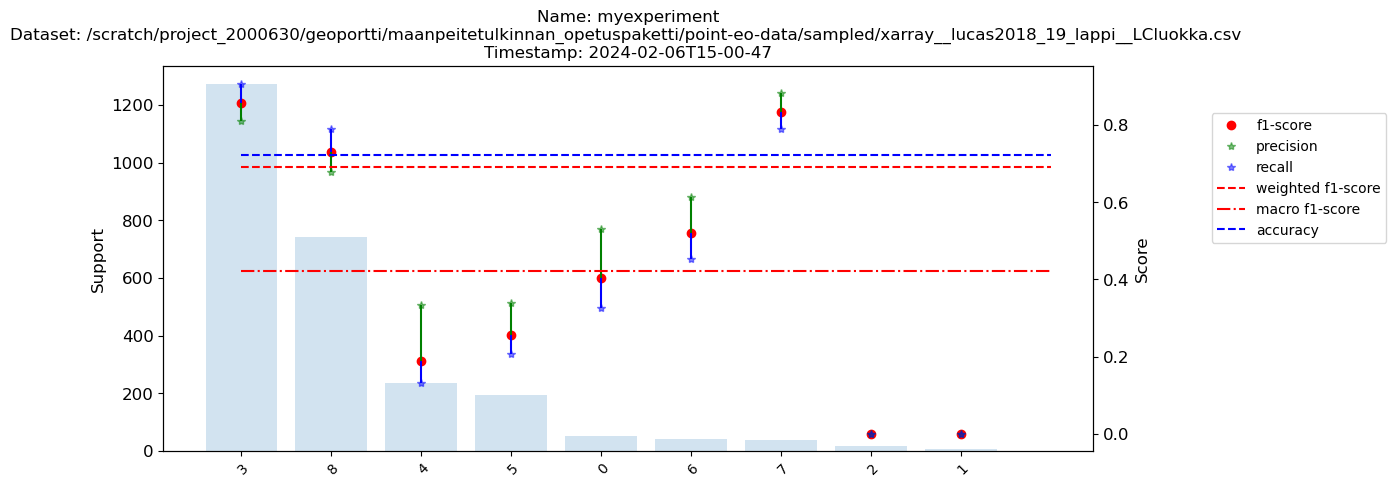

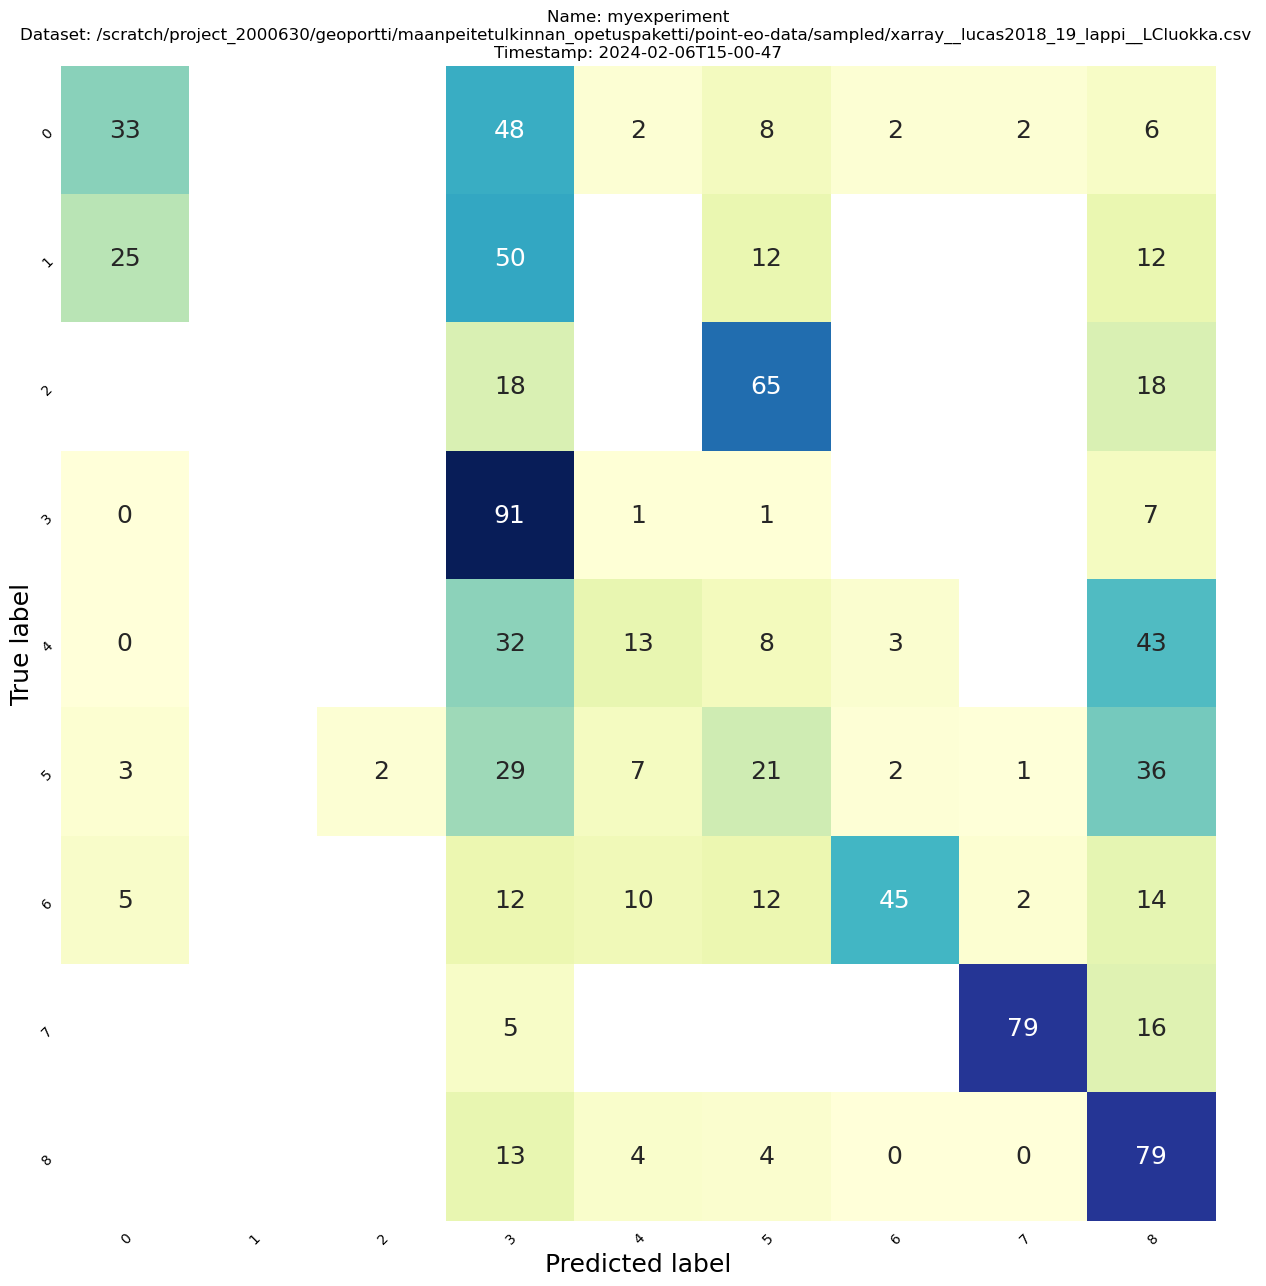

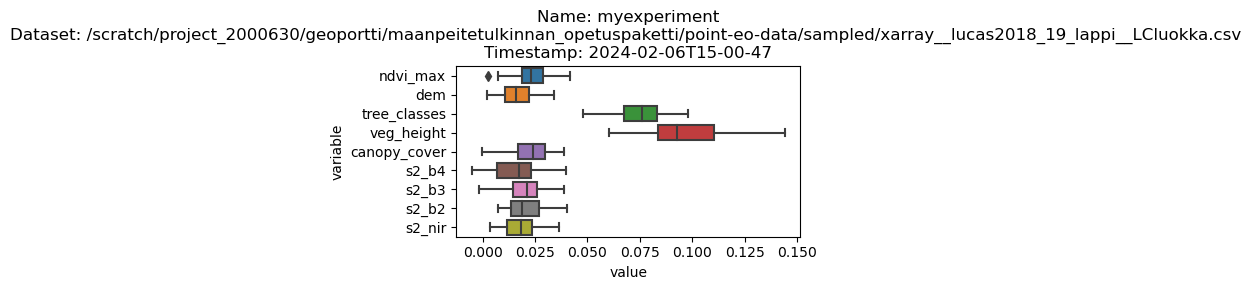

In [9]:
####  Training, analysis with the defaults (Random Forest)
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
analysis.add_args(subparsers)
args = parser.parse_args(['analysis',
    '--input', os.path.join(basepth,'sampled','xarray__lucas2018_19_lappi__LCluokka.csv'),
    '--out_folder', os.path.join(basepth,'model_fitting_RF'),
    '--out_prefix', 'myexperiment',
    '--decimal', '.',
    '--separator',','])
analysis.main(args)

## Inference with the point-eo library
### First with TPOT-model 
 

In [ ]:
bbox  = [484280.9100000000325963,7693860.217000000178813,526940.9100000000325963,7730770.2170000001788139]


Fx = cube.where((bbox[0] < cube.x) & (cube.x < bbox[2])
         & (bbox[1] < cube.y) & (cube.y < bbox[3]), drop=True).to_array().squeeze()

# Load tpot-model from analysis step
with open(os.path.join(basepth,'model_fitting_tpot','myexperiment__xarray__lucas2018_19_lappi__LCluokka__2024-02-06T14-59-41_model.pkl'), "rb") as f:
    TPOT_model = pickle.load(f)


# cell size of the interference blocks
grid_cells = predict.create_cell_grid(Fx, 10000)
predict.calculate(model = TPOT_model,
                  Fx = Fx,
                  cell_list = grid_cells,
                  verbose=2,
                  out_folder = os.path.join(basepth,'predict_output_tpot'))
# Combine blocks
predict.merge_folder(os.path.join(basepth,'predict_output_tpot'),
                     os.path.join(basepth,"out_tpot.vrt"))

#### postprocess_prediction, creates 2 tiff files
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
postprocess_prediction.add_args(subparsers)
args = parser.parse_args(['postprocess_prediction',
    '--input_raster', os.path.join(basepth,"out_tpot.vrt"),
    '--out_folder', os.path.join(basepth,'postprocess_tpot')
    ])
postprocess_prediction.main(args)


# Save as geotiff
Rx = rxr.open_rasterio(
    os.path.join(basepth,"out_tpot.vrt"),
    chunks={"band": -1, "x": 2**10, "y": 2**10},
    lock=False,
    parallel=True,
)
Rx.rio.to_raster(os.path.join(basepth,'myresult_tpot.tif'))

  3%|▎         | 1/30 [00:00<00:23,  1.23it/s]

NoDataInBounds in 0


  7%|▋         | 2/30 [00:01<00:17,  1.61it/s]

NoDataInBounds in 1


 10%|█         | 3/30 [00:01<00:15,  1.79it/s]

NoDataInBounds in 2


 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]

NoDataInBounds in 3


 17%|█▋        | 5/30 [00:02<00:11,  2.12it/s]

NoDataInBounds in 4


 20%|██        | 6/30 [00:15<01:52,  4.67s/it]

SAVED 5


 23%|██▎       | 7/30 [00:27<02:43,  7.11s/it]

SAVED 6


 27%|██▋       | 8/30 [00:39<03:13,  8.79s/it]

SAVED 7


 30%|███       | 9/30 [00:48<03:03,  8.73s/it]

SAVED 8


 33%|███▎      | 10/30 [00:48<02:02,  6.15s/it]

NoDataInBounds in 9


 37%|███▋      | 11/30 [01:01<02:33,  8.10s/it]

SAVED 10


 40%|████      | 12/30 [01:14<02:51,  9.54s/it]

SAVED 11


 43%|████▎     | 13/30 [01:26<02:57, 10.47s/it]

SAVED 12


 47%|████▋     | 14/30 [01:36<02:41, 10.09s/it]

SAVED 13


 50%|█████     | 15/30 [01:36<01:47,  7.16s/it]

NoDataInBounds in 14


 53%|█████▎    | 16/30 [01:48<02:02,  8.72s/it]

SAVED 15


 57%|█████▋    | 17/30 [02:01<02:08,  9.89s/it]

SAVED 16


 60%|██████    | 18/30 [02:14<02:08, 10.71s/it]

SAVED 17


 63%|██████▎   | 19/30 [02:23<01:53, 10.34s/it]

SAVED 18


 67%|██████▋   | 20/30 [02:23<01:13,  7.35s/it]

NoDataInBounds in 19


 70%|███████   | 21/30 [02:36<01:19,  8.80s/it]

SAVED 20


 73%|███████▎  | 22/30 [02:48<01:18,  9.84s/it]

SAVED 21


 77%|███████▋  | 23/30 [03:00<01:14, 10.61s/it]

SAVED 22


 80%|████████  | 24/30 [03:09<01:00, 10.15s/it]

SAVED 23


 83%|████████▎ | 25/30 [03:10<00:36,  7.22s/it]

NoDataInBounds in 24


 87%|████████▋ | 26/30 [03:13<00:24,  6.02s/it]

SAVED 25


 90%|█████████ | 27/30 [03:16<00:15,  5.24s/it]

SAVED 26


 93%|█████████▎| 28/30 [03:20<00:09,  4.65s/it]

SAVED 27


 97%|█████████▋| 29/30 [03:22<00:04,  4.00s/it]

SAVED 28


100%|██████████| 30/30 [03:22<00:00,  6.77s/it]

NoDataInBounds in 29
Writing .vrt file...


0...10...20...30...40...50...60...70...80...90...100 - done.


### Then with RF-model

In [15]:
# load rf-model from the analysis stem
with open(os.path.join(basepth,'model_fitting_RF','myexperiment__xarray__lucas2018_19_lappi__LCluokka__2024-02-06T11-04-12_model.pkl'), "rb") as f:
    RF_model = pickle.load(f)

predict.calculate(model = RF_model,
                  Fx = Fx,
                  cell_list = grid_cells,
                  verbose=2,
                  out_folder = os.path.join(basepth,'predict_output_RF'))
# Combine blocks
predict.merge_folder(os.path.join(basepth,'predict_output_RF'),
                     os.path.join(basepth,"out_RF.vrt"))

# Save as geotiff
Rx = rxr.open_rasterio(
    os.path.join(basepth,"out_RF.vrt"),
    chunks={"band": -1, "x": 2**10, "y": 2**10},
    lock=False,
    parallel=True,
)
Rx.rio.to_raster(os.path.join(basepth,'myresult_RF.tif'))


#### postprocess_prediction, creates 2 tiff files
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
postprocess_prediction.add_args(subparsers)
args = parser.parse_args(['postprocess_prediction',
    '--input_raster', os.path.join(basepth,"out_RF.vrt"),
    '--out_folder', os.path.join(basepth,'postprocess_RF')
    ])
postprocess_prediction.main(args)

  3%|▎         | 1/30 [00:00<00:18,  1.53it/s]

NoDataInBounds in 0


  7%|▋         | 2/30 [00:01<00:14,  1.87it/s]

NoDataInBounds in 1


 10%|█         | 3/30 [00:01<00:13,  1.99it/s]

NoDataInBounds in 2


 13%|█▎        | 4/30 [00:02<00:12,  2.06it/s]

NoDataInBounds in 3


 17%|█▋        | 5/30 [00:02<00:10,  2.28it/s]

NoDataInBounds in 4


 20%|██        | 6/30 [00:14<01:42,  4.25s/it]

SAVED 5


 23%|██▎       | 7/30 [00:25<02:30,  6.56s/it]

SAVED 6


 27%|██▋       | 8/30 [00:36<02:58,  8.13s/it]

SAVED 7


 30%|███       | 9/30 [00:44<02:48,  8.00s/it]

SAVED 8


 33%|███▎      | 10/30 [00:44<01:52,  5.64s/it]

NoDataInBounds in 9


 37%|███▋      | 11/30 [00:56<02:21,  7.45s/it]

SAVED 10


 40%|████      | 12/30 [01:08<02:37,  8.73s/it]

SAVED 11


 43%|████▎     | 13/30 [01:20<02:44,  9.68s/it]

SAVED 12


 47%|████▋     | 14/30 [01:28<02:28,  9.30s/it]

SAVED 13


 50%|█████     | 15/30 [01:28<01:39,  6.60s/it]

NoDataInBounds in 14


 53%|█████▎    | 16/30 [01:40<01:52,  8.06s/it]

SAVED 15


 57%|█████▋    | 17/30 [01:51<01:58,  9.12s/it]

SAVED 16


 60%|██████    | 18/30 [02:03<01:58,  9.90s/it]

SAVED 17


 63%|██████▎   | 19/30 [02:11<01:44,  9.47s/it]

SAVED 18


 67%|██████▋   | 20/30 [02:12<01:07,  6.74s/it]

NoDataInBounds in 19


 70%|███████   | 21/30 [02:23<01:12,  8.08s/it]

SAVED 20


 73%|███████▎  | 22/30 [02:35<01:12,  9.10s/it]

SAVED 21


 77%|███████▋  | 23/30 [02:46<01:08,  9.84s/it]

SAVED 22


 80%|████████  | 24/30 [02:54<00:55,  9.31s/it]

SAVED 23


 83%|████████▎ | 25/30 [02:55<00:33,  6.63s/it]

NoDataInBounds in 24


 87%|████████▋ | 26/30 [02:57<00:22,  5.51s/it]

SAVED 25


 90%|█████████ | 27/30 [03:01<00:14,  4.78s/it]

SAVED 26


 93%|█████████▎| 28/30 [03:04<00:08,  4.24s/it]

SAVED 27


 97%|█████████▋| 29/30 [03:06<00:03,  3.65s/it]

SAVED 28


100%|██████████| 30/30 [03:06<00:00,  6.22s/it]

NoDataInBounds in 29
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


Saved S and M rasters


## Visualisation of the results

Open the RF_S and tpot_S rasters, found in the outputfolder of the postprocessing step, in QGIS and visually evaluate the prediction performance and write a written summary about it 